# TCW, WOfS, Fractional Cover all together now

| Authors:  | Bex Dunn|
|----------|----------------|
| Created: | Jan 7, 2019 |
| Last edited: | Jan 8, 2019 |

**Requirements:**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

__Background:__ Data from the [Landsat](https://landsat.usgs.gov/about-landsat) 5,7 and 8 satellite missions are accessible through [Digital Earth Australia](http://www.ga.gov.au/about/projects/geographic/digital-earth-australia) (DEA). The code snippets in this notebook will let you retrieve and plot the [Fractional Cover](https://d28rz98at9flks.cloudfront.net/79676/Fractional_Cover_FC25_v1_5.PDF) (FC25) data stored in DEA.

__What does this notebook do?:__ This notebook ###FIXME
''' Polygon drill, TCW, WOfS, FC, then stacked bar plot '''
    
__How to use this notebook:__

A basic understanding of any programming language is desirable but one doesn't have to be an expert Python programmer to manipulate the code to get and display the data.This doc applies to the following Landsat satellites, Fractional Cover bands and the WOfS dataset:

- Landsat 5
- Landsat 7
- Landsat 8
- PV - Photosythetic vegetation
- NPV - Non-Photosythetic vegetation
- BS - Bare Soil
- UE - Unmixing Error
- Water Observations from Space (WOFs)
- WOfS Feature Layer (WOFL)




__Bugs to fix:__ 
- calculate pixels per scene for wofs and tcw
- try alternative method of calculating FC as most prevalent in pixel
- try masking out the AOI so you're looking within a polygon extent 
- do this by max extent of wetness
        

### import some modules


In [148]:
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
#import shapely.geometry

sys.path.append('../10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools, SpatialTools

dc = datacube.Datacube(app='tci and wofs')

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up polygon

In [149]:
#change the path here if you want a different polygon
#poly_path = '/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_shapefiles/reeves_lake_for_demo.shp'
poly_path = '/g/data/r78/SA_mound_springs/BigBlythe.shp'

In [150]:
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

<Figure size 432x288 with 0 Axes>

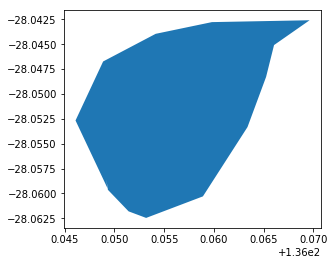

In [151]:
#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()
plt.show()

### Set up query

In [152]:
query = {'geopolygon': geom,
         #'time': ('2016-01-01', '2016-06-30')
         #'time': ('2007-01-01', '2007-06-30')
         'time': ('1986-01-01', '2019-01-30')
         }

## Set up datasets

### set cloudmasking threshold and load landsat nbart data

In [155]:
#set cloudmasking threshold and load landsat nbart data
landsat_masked_prop = 0.90
ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart',
        masked_prop=landsat_masked_prop)

Loading ls5 pixel quality
    Loading 280 filtered ls5 timesteps
Ignoring SLC-off observations for ls7
Loading ls7 pixel quality
    Loading 65 filtered ls7 timesteps
Loading ls8 pixel quality
    Loading 96 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### mask the data with our original polygon to remove extra data 

In [248]:
data = ls578_ds
mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs)for geoms in [geom]],
                                           out_shape=data.geobox.shape,
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=False)

In [250]:
#for some reason xarray is not playing nicely with our old masking function
mask_xr = xr.DataArray(mask, dims = ('y','x'))

In [260]:
ls578_ds = data.where(mask_xr==False)

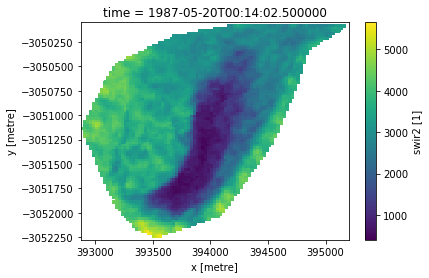

In [261]:
#plot nbart|
ls578_ds.swir2.isel(time=0).plot()

In [262]:
#transform the nbart into tci
tci = TasseledCapTools.thresholded_tasseled_cap(ls578_ds,wetness_threshold=-1200, drop=True , drop_tc_bands=True)

### plot the overthreshold wetness

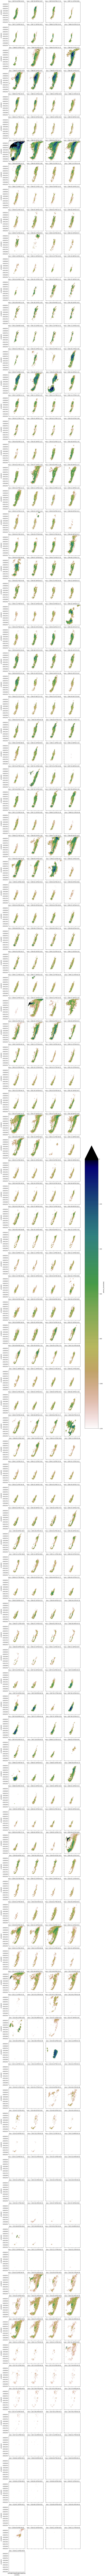

In [264]:
#plot the first time slice of wetness
tci.wetness_thresholded.plot(col='time', 
                             col_wrap=4, cmap = 'gist_earth_r',
                             vmin = -1200, vmax = 0)

### create a masked version of the extent of overthreshold wetness

In [265]:
#select only finite values (over threshold values)
tcw = xr.ufuncs.isfinite(tci.wetness_thresholded)

In [329]:
#reapply the polygon mask
tcw = tcw.where(mask_xr==False)

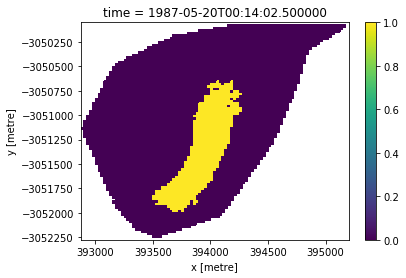

In [330]:
#plot the first timestep again to check the mask
tcw.isel(time=0).plot()

### load wofls and select only wet pixels

In [267]:
### define wofs
#wofls = dc.load(product='wofs_albers', **query)
wofls = dc.load(product = 'wofs_albers', like=ls578_ds)

/g/data/v10/public/modules/dea/20181015/lib/python3.6/site-packages/datacube/api/query.py:93: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if like:


In [268]:
#only get wet obs as a boolean
wetwofl = masking.make_mask(wofls, wet=True)

In [269]:
#match the wofs observations to the nbart
wetwofl=wetwofl.where(wofls.time==ls578_ds.time)

In [ ]:
#mask the wofs obs

In [272]:
#mask the wofs obs with the polygon mask
wetwofl = wetwofl.where(mask_xr==False)

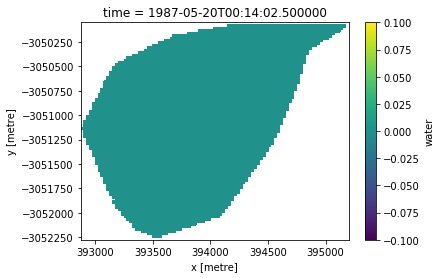

In [273]:
#plot wofs
wetwofl.water.isel(time=0).plot()

### load in fractional cover data

In [274]:
#load the data according to our query
#choose a mask proportion to look for a clear timestep
fc_ds = DEADataHandling.load_clearlandsat(dc, query,product='fc',masked_prop=0.90)

Loading ls5 pixel quality
    Loading 280 filtered ls5 timesteps
Ignoring SLC-off observations for ls7
Loading ls7 pixel quality
    Loading 65 filtered ls7 timesteps
Loading ls8 pixel quality
    Loading 96 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [275]:
#just a scene we want to plot - this can be done other ways
scene = 0

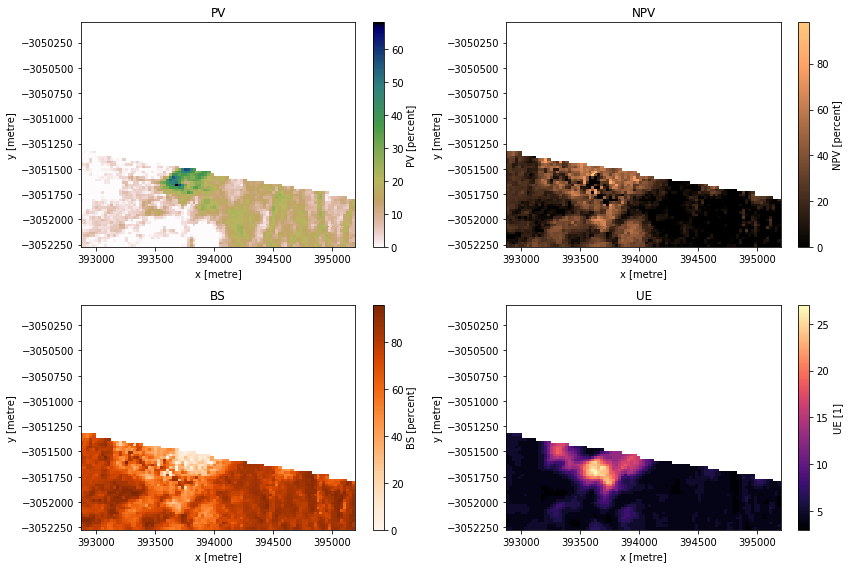

In [170]:
#set up our images on a grid using gridspec
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
fc_ds.PV.isel(time=scene).plot(cmap='gist_earth_r')
ax1.set_title('PV')

ax2=plt.subplot(gs[1,0])
fc_ds.BS.isel(time=scene).plot(cmap='Oranges')
ax2.set_title('BS')

ax3=plt.subplot(gs[0,1])
fc_ds.NPV.isel(time=scene).plot(cmap='copper')
ax3.set_title('NPV')

ax4=plt.subplot(gs[1,1])
fc_ds.UE.isel(time=scene).plot(cmap='magma')
ax4.set_title('UE')

plt.tight_layout()
plt.show()

### mask FC with polygon

In [276]:
fc_ds = fc_ds.where(mask_xr==False)

### mask FC with wetness

In [277]:
fc_ds_noTCW=fc_ds.where(tcw==False)

### count wet, wofs, bs, pv, npv

In [331]:
pixels = tcw.count(dim=['x','y'])

In [279]:
# count wet, wofs,
#count number of wofs pixels
wofs_pixels = wetwofl.water.sum(dim=['x','y'])

#count percentage of area of wofs
wofs_area_percent = (wofs_pixels/pixels)*100

#count number of tcw pixels
tcw_pixels = tcw.sum(dim=['x','y'])

#calculate percentage area wet
tcw_area_percent = (tcw_pixels/pixels)*100

#calculate wet not wofs
tcw_less_wofs = tcw_area_percent-wofs_area_percent

In [280]:
#count non_water/non_nan pixels in each timestep
non_water_pixels = fc_ds_noTCW.count(dim=['x','y'])

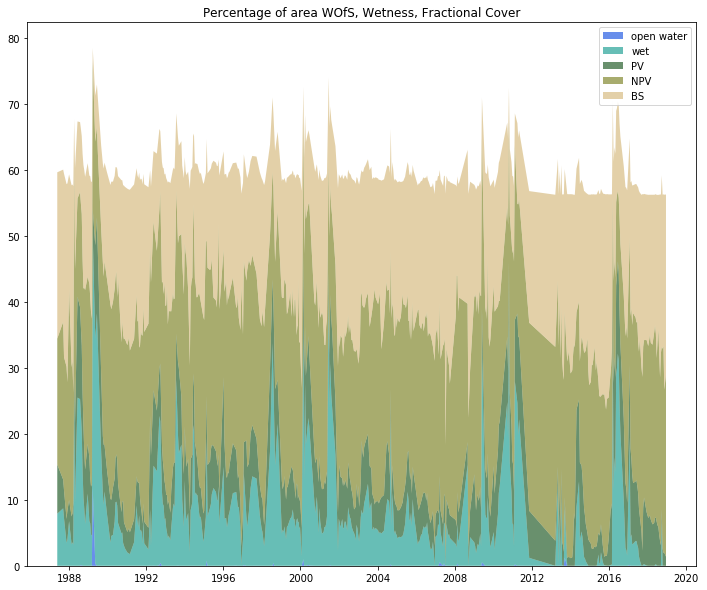

In [281]:
percentage_multiplier = (100 - tcw_area_percent)

fc_bs_pc = (fc_ds.BS.sum(dim=['x','y']))/(pixels) *percentage_multiplier/100
fc_pv_pc = (fc_ds.PV.sum(dim=['x','y']))/(pixels) *percentage_multiplier/100
fc_npv_pc = (fc_ds.NPV.sum(dim=['x','y']))/(pixels) *percentage_multiplier/100

#set up color palette
pal = [sns.xkcd_rgb["blue"],
       sns.xkcd_rgb["teal"],
       sns.xkcd_rgb["forest green"],
       sns.xkcd_rgb["olive"],
       sns.xkcd_rgb["tan"]]

#make a stacked area plot
plt.figure(figsize=(12,10))
plt.stackplot(wofs_area_percent.time.values, 
              wofs_area_percent, 
              tcw_less_wofs, 
              fc_pv_pc, 
              fc_npv_pc, 
              fc_bs_pc,  
              labels=['open water',
                      'wet',
                      'PV',
                      'NPV',
                      'BS'], colors=pal, alpha = 0.6)
plt.title('Percentage of area WOfS, Wetness, Fractional Cover')
plt.legend(loc='upper right')
plt.show()

### Calculate the dominant fraction for each pixel in Fractional Cover

In [282]:
#drop data percentage and Unmixing Error
fc_tester = fc_ds_noTCW.drop(['data_perc','UE'])

In [283]:
#following robbi's advice, cast the dataset to a dataarray
maxFC = fc_tester.to_array(dim='variable', name='maxFC')

In [284]:
#turn FC array into integer only as nanargmax doesn't seem to handle floats the way we want it to
FC_int = maxFC.astype('int8')

In [285]:
#use numpy.nanargmax to get the index of the maximum value along the variable dimension
BSPVNPV=np.nanargmax(FC_int, axis=0)

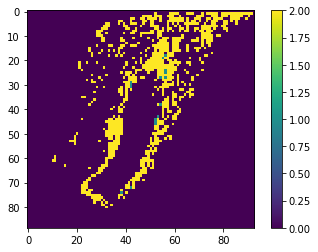

In [286]:
#plot the results to check they look roughly like what we are expecting
plt.imshow(BSPVNPV[0])
plt.colorbar()

In [ ]:
#rebuild the DataArray from the munged numpy array
FC_dominant= xr.DataArray(BSPVNPV, coords = fc_ds.coords, 
                          dims = ('time','y','x'),
                         attrs = fc_ds.attrs)

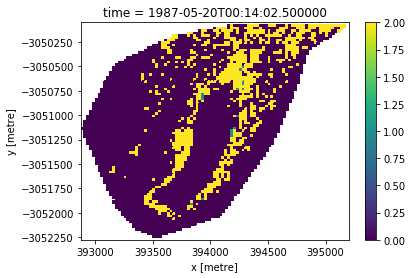

In [294]:
#filter out 0 values caused by mask
FC_dominant = FC_dominant.where(mask_array==False)
FC_dominant.isel(time=0).plot()

In [309]:
## create a data array with BS, PV, NPV separate
### FIXME turn these into booleans
### FIXME : Check these are variables not coords
FC_dominant['BS'] = FC_dominant.where(FC_dominant==0)
FC_dominant['PV'] = FC_dominant.where(FC_dominant==1)
FC_dominant['NPV'] = FC_dominant.where(FC_dominant==2)

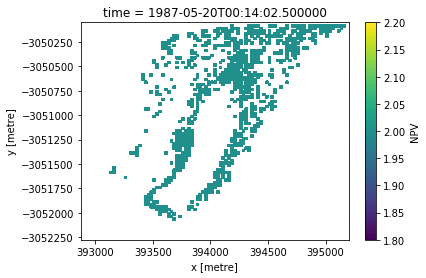

In [318]:
FC_dominant['NPV'].isel(time=0).plot()

In [320]:
pixels

<xarray.DataArray 'wetness_thresholded' (time: 441)>
array([8277, 8277, 8277, ..., 8277, 8277, 8277])
Coordinates:
  * time     (time) datetime64[ns] 1987-05-20T00:14:02.500000 ... 2018-12-19T00:49:58

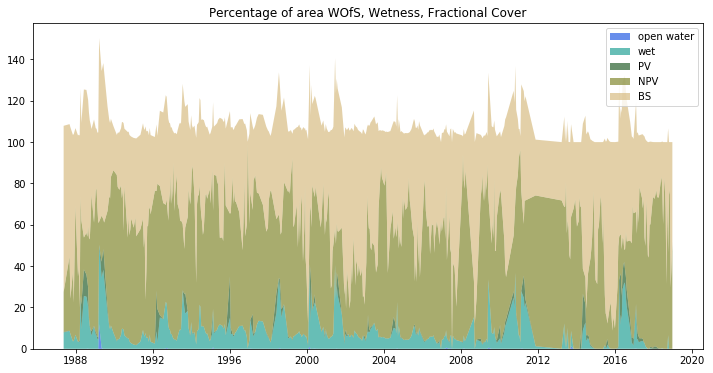

In [339]:
#Fractional cover pixel count method
#Get number of pixels, divide by total number of pixels per scene
FC_bs_pc = ((FC_dominant.BS.count(dim=['x','y']))/(pixels-) )*100
FC_pv_pc = ((FC_dominant.PV.count(dim=['x','y']))/(pixels))*100 
FC_npv_pc = ((FC_dominant.NPV.count(dim=['x','y']))/(pixels) )*100
#set up color palette
pal = [sns.xkcd_rgb["blue"],
       sns.xkcd_rgb["teal"],
       sns.xkcd_rgb["forest green"],
       sns.xkcd_rgb["olive"],
       sns.xkcd_rgb["tan"]]

#make a stacked area plot
plt.figure(figsize = (12,6))
plt.stackplot(wofs_area_percent.time.values, 
              wofs_area_percent, 
              tcw_less_wofs, 
              FC_pv_pc, 
              FC_npv_pc, 
              FC_bs_pc,  
              labels=['open water',
                      'wet',
                      'PV',
                      'NPV',
                      'BS'], colors=pal, alpha = 0.6)

plt.title('Percentage of area WOfS, Wetness, Fractional Cover')
plt.legend(loc='upper right')
plt.show()